In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("./data/lfw/*/*"))
dog_files = np.array(glob("./data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 5749 total human images.
There are 8351 total dog images.


Number of faces detected: 1


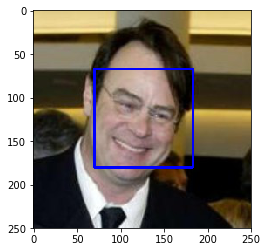

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

img = cv2.imread(human_files[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray)
print('Number of faces detected:', len(faces))

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()

In [3]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [4]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

human_percentage = 0
dog_percentage = 0
for i in range(len(human_files_short)):
    if face_detector(human_files_short[i]):
        human_percentage += 1 
    if face_detector(dog_files_short[i]):
        dog_percentage += 1 
print('Percentage of human faces detected on human images: ', human_percentage, '%\nPercentage of human faces detected on dog images', dog_percentage, '%')

Percentage of human faces detected on human images:  98 %
Percentage of human faces detected on dog images 17 %


In [4]:
import torch
import torchvision.models as models

VGG16 = models.vgg16(pretrained=True)

use_cuda = torch.cuda.is_available()

if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 102497483.60it/s]


In [5]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to predicted ImageNet
    class for image at specified path
    '''

    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    image = Image.open(img_path).convert('RGB')
    image = transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    predict = VGG16(image)
    return predict.data.cpu().argmax()

In [6]:
def dog_detector(img_path):
    index = VGG16_predict(img_path)
    return index >= 151 and index <= 268

In [8]:
human_percentage = 0
dog_percentage = 0

for i in range(len(human_files_short)):
    human_percentage += int(dog_detector(human_files_short[i]))

for i in range(len(dog_files_short)):
    dog_percentage += int(dog_detector(dog_files_short[i]))

print('Percentage of dog faces detected on human images: ', human_percentage, '%\nPercentage of dog faces detected on dog images', dog_percentage, '%')

Percentage of dog faces detected on human images:  1 %
Percentage of dog faces detected on dog images 100 %


In [7]:
import os
from torchvision import datasets

data_dir = '/data/dog_images/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

transform = {
    'train': transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

train_set = datasets.ImageFolder(train_dir, transform=transform['train'])
valid_set = datasets.ImageFolder(valid_dir, transform=transform['train'])
test_set = datasets.ImageFolder(test_dir, transform=transform['test'])

train_data = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=20, shuffle=False)
test_data = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 133)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        return x

model_scratch = Net()
if use_cuda:
    model_scratch.cuda()

In [11]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer_scratch.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss_min > valid_loss:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            print('Saving model.')
            
    return model

loaders_scratch = {
    'train': train_data,
    'valid': valid_data,
    'test': test_data
}
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.856456 	Validation Loss: 4.780464
Saving model.
Epoch: 2 	Training Loss: 4.711460 	Validation Loss: 4.647180
Saving model.
Epoch: 3 	Training Loss: 4.577959 	Validation Loss: 4.594058
Saving model.
Epoch: 4 	Training Loss: 4.460397 	Validation Loss: 4.432564
Saving model.
Epoch: 5 	Training Loss: 4.307676 	Validation Loss: 4.319126
Saving model.
Epoch: 6 	Training Loss: 4.184033 	Validation Loss: 4.259361
Saving model.
Epoch: 7 	Training Loss: 4.078992 	Validation Loss: 4.212890
Saving model.
Epoch: 8 	Training Loss: 3.995225 	Validation Loss: 4.163255
Saving model.
Epoch: 9 	Training Loss: 3.896964 	Validation Loss: 4.201874
Epoch: 10 	Training Loss: 3.786278 	Validation Loss: 4.090811
Saving model.
Epoch: 11 	Training Loss: 3.686944 	Validation Loss: 4.071714
Saving model.
Epoch: 12 	Training Loss: 3.566757 	Validation Loss: 4.184616
Epoch: 13 	Training Loss: 3.444950 	Validation Loss: 4.194410
Epoch: 14 	Training Loss: 3.314154 	Validation Loss: 4.177258
E

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [29]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.038152


Test Accuracy: 10% (89/836)


In [8]:
import torchvision.models as models
import torch.nn as nn

loaders_transfer = loaders_scratch
model_transfer = models.vgg16(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133, bias=True)
model_transfer.classifier[6] = last_layer
if use_cuda:
    model_transfer = model_transfer.cuda()
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

In [27]:
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.310824 	Validation Loss: 1.295281
Saving model.
Epoch: 2 	Training Loss: 1.331956 	Validation Loss: 0.744810
Saving model.
Epoch: 3 	Training Loss: 0.903799 	Validation Loss: 0.616346
Saving model.
Epoch: 4 	Training Loss: 0.716288 	Validation Loss: 0.529885
Saving model.
Epoch: 5 	Training Loss: 0.601759 	Validation Loss: 0.512923
Saving model.
Epoch: 6 	Training Loss: 0.534861 	Validation Loss: 0.473488
Saving model.
Epoch: 7 	Training Loss: 0.447411 	Validation Loss: 0.494860
Epoch: 8 	Training Loss: 0.399854 	Validation Loss: 0.458000
Saving model.
Epoch: 9 	Training Loss: 0.356993 	Validation Loss: 0.430481
Saving model.
Epoch: 10 	Training Loss: 0.312127 	Validation Loss: 0.456506


In [16]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.485669


Test Accuracy: 86% (722/836)


In [9]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
class_names = [item[4:].replace("_", " ") for item in train_set.classes]

def predict_breed_transfer(img_path):
    image = Image.open(img_path).convert('RGB')
    image_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    image = image_transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    output = model_transfer(image)
    return class_names[output.data.cpu().argmax()]

In [10]:
def run_app(img_path):
    predicted_breed = predict_breed_transfer(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if dog_detector(img_path):
        print("It's a dog. Predicted breed:", predicted_breed)
    elif face_detector(img_path):
        print("It's a human. Closest dog breed resemblance:", predicted_breed)
    else:
        print('Error: Neither human nor dog.')

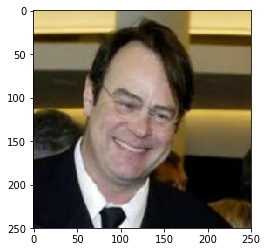

It's a human. Closest dog breed resemblance: Irish terrier


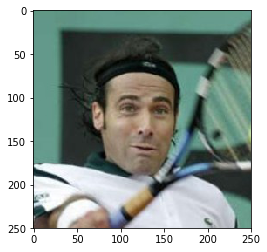

It's a human. Closest dog breed resemblance: American staffordshire terrier


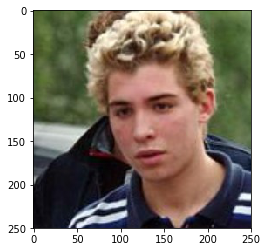

It's a human. Closest dog breed resemblance: Afghan hound


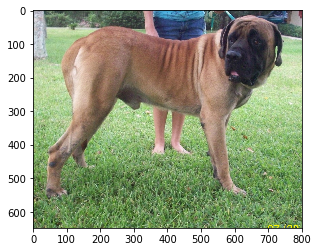

It's a dog. Predicted breed: Bullmastiff


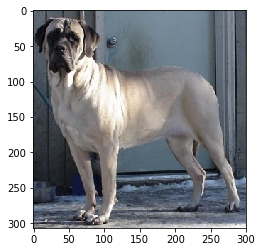

It's a dog. Predicted breed: Mastiff


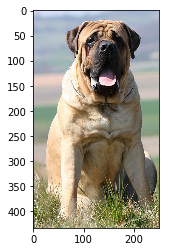

It's a dog. Predicted breed: Bullmastiff


In [15]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

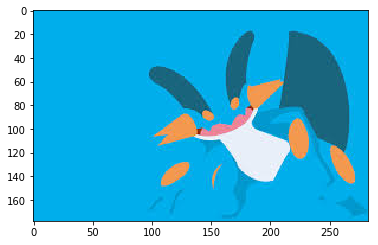

Error: Neither human nor dog.


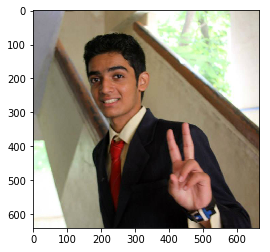

It's a human. Closest dog breed resemblance: Dachshund


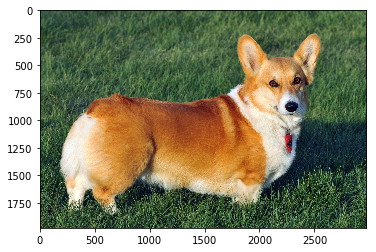

It's a dog. Predicted breed: Pembroke welsh corgi


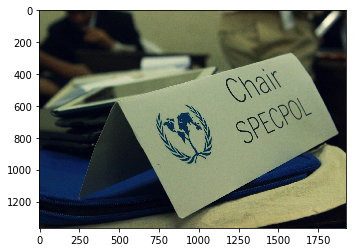

Error: Neither human nor dog.


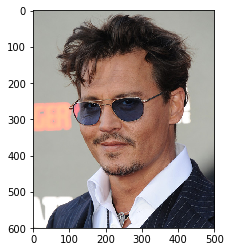

It's a human. Closest dog breed resemblance: Irish terrier


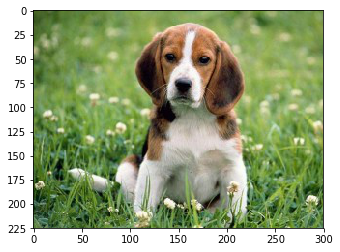

It's a dog. Predicted breed: Beagle


In [25]:
for file in os.listdir('./my_images/'):
    if 'jpg' in file:
        run_app(os.path.join('./my_images/',file))